<a href="https://colab.research.google.com/github/Pari510/website/blob/main/Task2b_final9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cuisine Classification Using NLP Models: A Comparative Study

This project aims to classify recipes into their respective cuisines using various natural language processing (NLP) models. The process involves data preprocessing, model training, hyperparameter optimization, and evaluation using multiple pre-trained models including DistilBERT, BERT (base and large), RoBERTa, and GPT-2. The performance of these models is compared to identify the most effective model for cuisine classification. Hyperparameter optimization is conducted to fine-tune the DistilBERT model for improved performance.  Interactive components are also implemented using Gradio for an intuitive user interface to explore and classify recipes.

## Setup and Installation of Required Packages

In [1]:
!pip install transformers datasets scikit-learn
!pip install optuna
!pip install optuna-integration
!pip install torch
!pip install python-docx
!pip install accelerate -U
!pip install gradio

## Importing Required Libraries

In [2]:
# Importing libraries for data manipulation and visualization
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import ast
from google.colab import files

# Importing libraries for machine learning and model evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Importing Hugging Face Transformers for NLP tasks
from transformers import (
    BertTokenizer, BertForSequenceClassification,
    DistilBertTokenizer, DistilBertForSequenceClassification,
    GPT2Tokenizer, GPT2ForSequenceClassification,
    RobertaTokenizer, RobertaForSequenceClassification,
    Trainer, TrainingArguments
)

# Importing datasets library for managing datasets
from datasets import Dataset, DatasetDict

# Importing additional libraries for numerical operations and visualization
import numpy as np
import seaborn as sns
import time
import random
import ast

# Importing PyTorch and optimization tools
import torch
import torch.optim as optim
from tqdm import tqdm

# Importing Optuna for hyperparameter optimization
import optuna

# Import Gradio
import gradio as gr

## Uploading and Loading Datasets


In [3]:
# Uploading files
uploaded = files.upload()

# Defining paths for the training and test data
training_data_path = 'Recipes_Training.csv'
test_data_path = 'Recipes_Test.csv'

# Loading the datasets into Pandas DataFrames
training_df = pd.read_csv(training_data_path, delimiter=';')
test_df = pd.read_csv(test_data_path, delimiter=';')

Saving Recipes_Test.csv to Recipes_Test (1).csv
Saving Recipes_Training.csv to Recipes_Training (1).csv


## Data Analysis and Visualization

In [4]:
# Function to Display DataFrame Information
def display_dataframe_info(df, df_name):
    """
    Prints the information and first few rows of a given DataFrame.

    Parameters:
    df (pd.DataFrame): The DataFrame to display information for.
    df_name (str): The name of the DataFrame.
    """
    print(f"\nInformationen zum {df_name} DataFrame:")
    print(df.info())
    print(f"\nErste Zeilen des {df_name} DataFrame:")
    print(df.head())
    print("\n")

# Function to Get Top Ingredients for Each Cuisine
def get_top_ingredients_by_cuisine(cuisine):
    """
    Returns the top 10 most common ingredients for a specified cuisine.

    Parameters:
    cuisine (str): The name of the cuisine to analyze.

    Returns:
    List[Tuple[str, int]]: A list of tuples containing the top ingredients and their counts.
    """
    # Filter the training data for the specified cuisine
    cuisine_data = training_df[training_df['cuisine'] == cuisine]

    # Initialize a list to store all ingredients for this cuisine
    all_ingredients = []

    # Loop through the ingredients lists, parse them, and extend the all_ingredients list
    for ingredients_list in cuisine_data['ingredients']:
        ingredients = ast.literal_eval(ingredients_list)
        all_ingredients.extend(ingredients)

    # Count the frequency of each ingredient
    ingredient_counts = Counter(all_ingredients)

    # Return the top 10 most common ingredients
    return ingredient_counts.most_common(10)


Informationen zum Trainings DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           8000 non-null   int64 
 1   cuisine      8000 non-null   object
 2   ingredients  8000 non-null   object
dtypes: int64(1), object(2)
memory usage: 187.6+ KB
None

Erste Zeilen des Trainings DataFrame:
      id      cuisine                                        ingredients
0  25693  southern_us  ['plain flour', 'ground pepper', 'salt', 'toma...
1  22213       indian        ['water', 'vegetable oil', 'wheat', 'salt']
2  13162       indian  ['black pepper', 'shallots', 'cornflour', 'cay...
3   3735      italian  ['sugar', 'pistachio nuts', 'white almond bark...
4  16903      mexican  ['olive oil', 'purple onion', 'fresh pineapple...



Informationen zum Test DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data

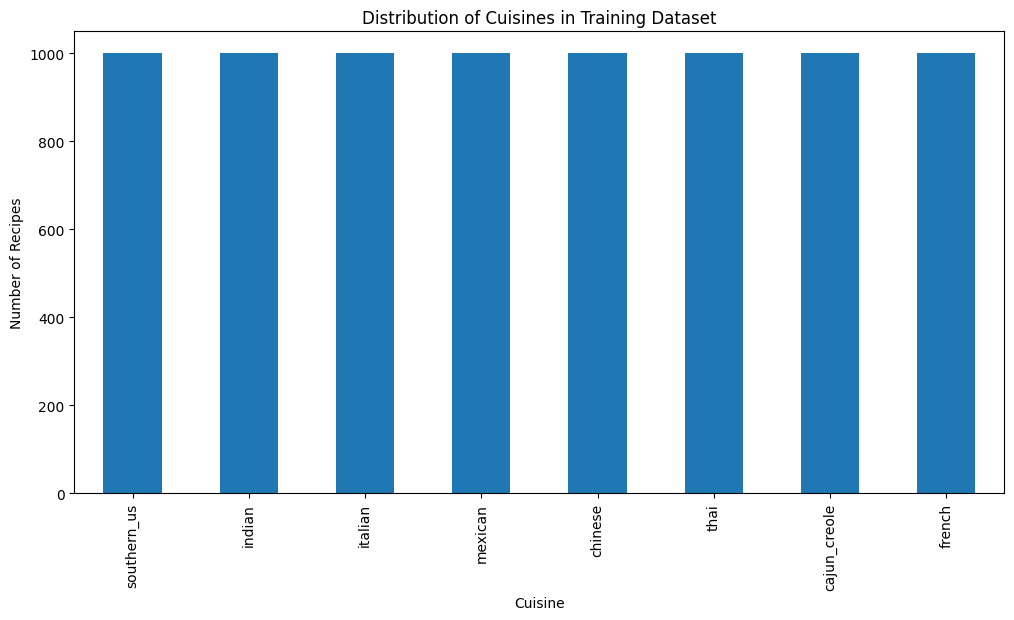

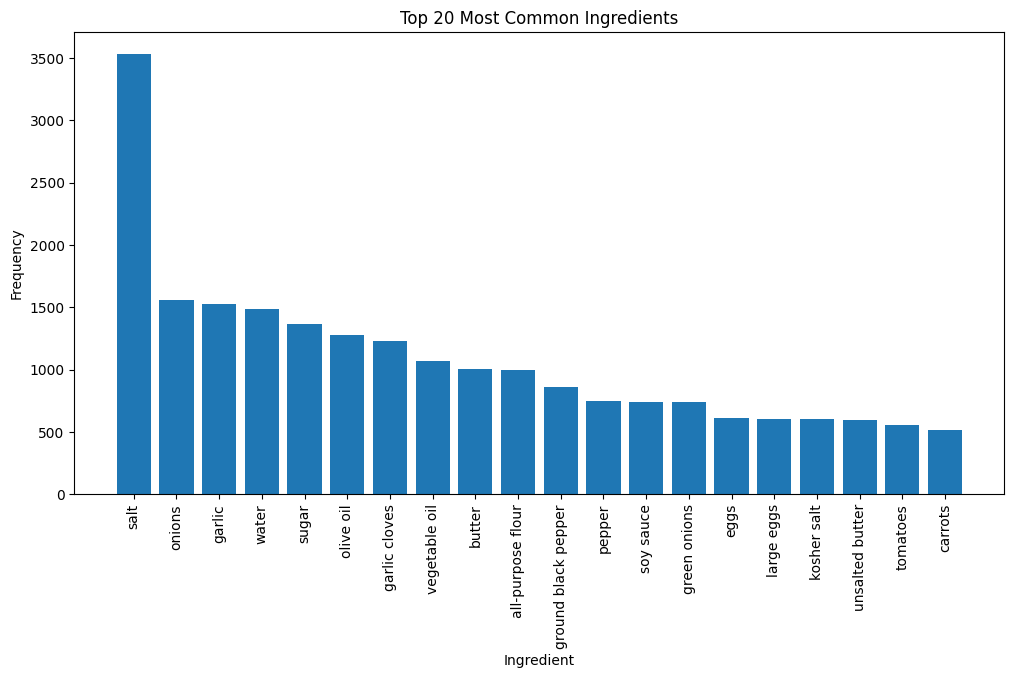

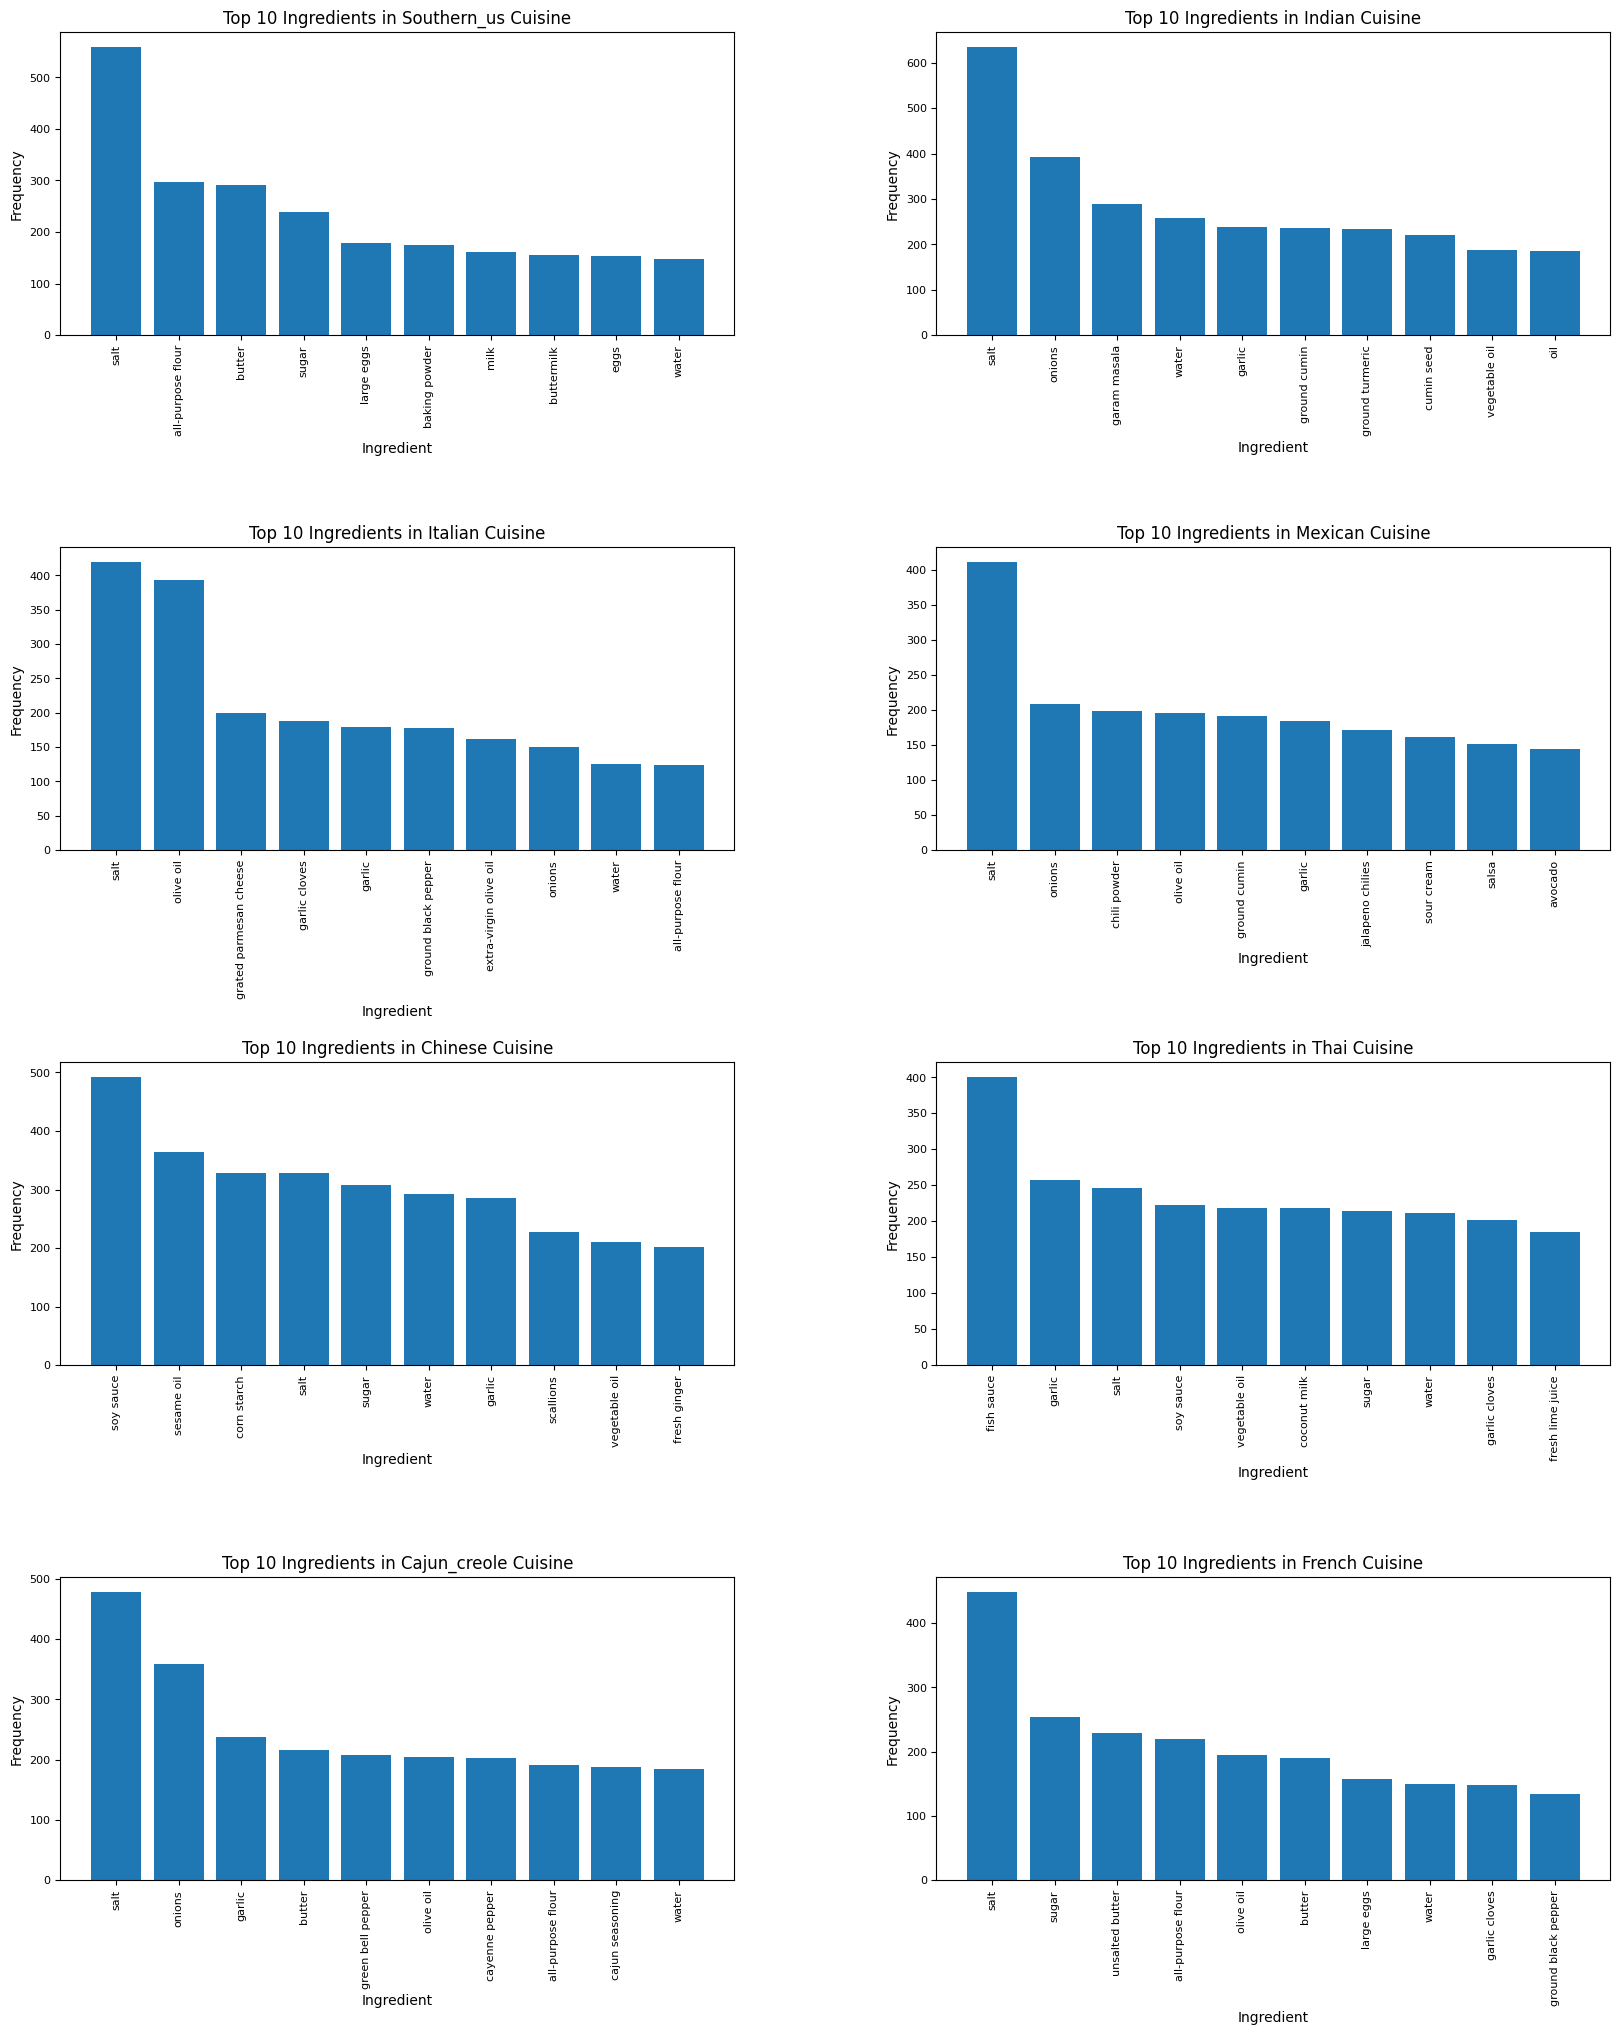

In [5]:
# Displaying information and first few rows of the training and test DataFrames
display_dataframe_info(training_df, "Trainings")
display_dataframe_info(test_df, "Test")

# Distribution of Cuisines in the Training Dataset
cuisine_counts = training_df['cuisine'].value_counts()
plt.figure(figsize=(12, 6))
cuisine_counts.plot(kind='bar')
plt.title('Distribution of Cuisines in Training Dataset')
plt.xlabel('Cuisine')
plt.ylabel('Number of Recipes')
plt.show()

# Most Common Ingredients
all_ingredients = []
for ingredients_list in training_df['ingredients']:
    ingredients = ast.literal_eval(ingredients_list)
    all_ingredients.extend(ingredients)

ingredient_counts = Counter(all_ingredients)

# Top 20 Most Common Ingredients
top_ingredients = ingredient_counts.most_common(20)
ingredients, counts = zip(*top_ingredients)
plt.figure(figsize=(12, 6))
plt.bar(ingredients, counts)
plt.title('Top 20 Most Common Ingredients')
plt.xlabel('Ingredient')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

# Top Ingredients for Each Cuisine
cuisines = training_df['cuisine'].unique()
top_ingredients_by_cuisine = {cuisine: get_top_ingredients_by_cuisine(cuisine) for cuisine in cuisines}

# Plotting Top Ingredients for Each Cuisine
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 24))
fig.subplots_adjust(hspace=0.7, wspace=0.3)

for ax, (cuisine, top_ingredients) in zip(axes.flatten(), top_ingredients_by_cuisine.items()):
    ingredients, counts = zip(*top_ingredients)
    ax.bar(ingredients, counts)
    ax.set_title(f'Top 10 Ingredients in {cuisine.capitalize()} Cuisine', fontsize=12)
    ax.set_xlabel('Ingredient', fontsize=10)
    ax.set_ylabel('Frequency', fontsize=10)
    ax.tick_params(axis='x', rotation=90, labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
plt.show()

### Summary of EDA Results

1. **Data Overview**:
   - Number of Entries: 8000
   - Columns: id, cuisine, ingredients
   - Non-Null Values: All columns have 8000 non-null values.
   - Data Types: id is an integer, cuisine and ingredients are objects (strings).

2. **Distribution of Cuisines**:
   - The distribution of different cuisines is balanced.

3. **Most Common Ingredients**:
   - The most frequently used ingredients are basic ones like salt, onions, garlic, and water, which are found in many recipes.

4. **Top Ingredients by Cuisine**:
   - Each cuisine has its own typical ingredients, reflecting its "unique" cooking styles.

## Splitting Training and Validation Data

The original dataset is split into training and validation datasets, with 20% of the data used for validation and 80% for training. Stratification ensures that the distribution of cuisines is similar in both datasets.

In [6]:
# Splitting Training and Validation Data
train_df, val_df = train_test_split(
    training_df,
    test_size=0.2,
    stratify=training_df['cuisine'],
    random_state=42
)

## Analysis of Token Counts per Recipe for Different Tokenizers

To determine the optimal sequence length (max_length), the token counts are calculated.

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


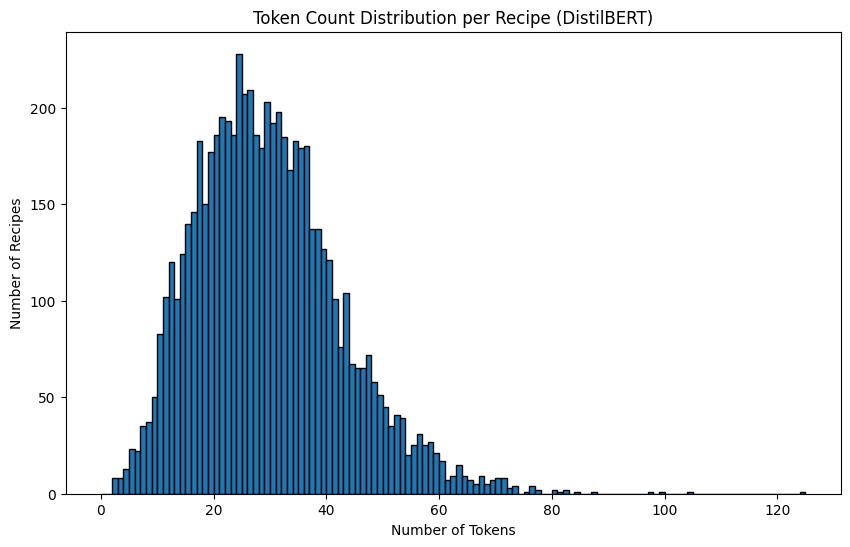

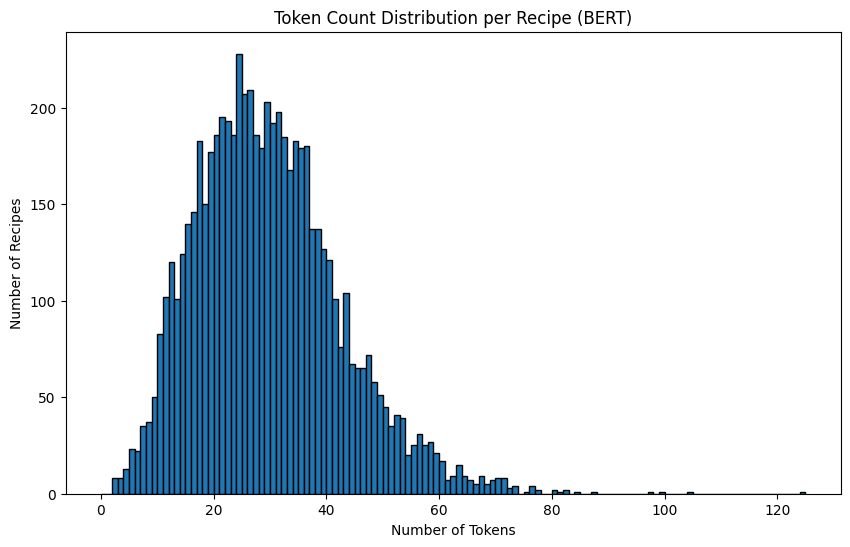

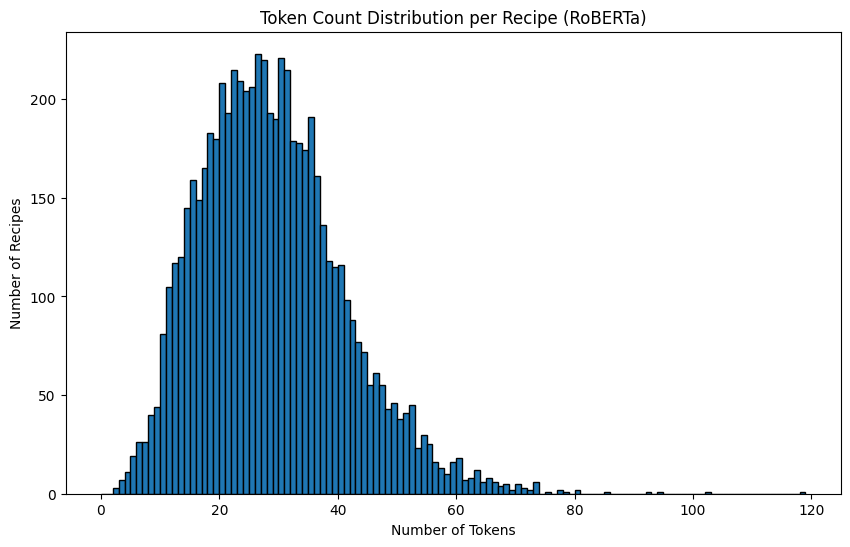

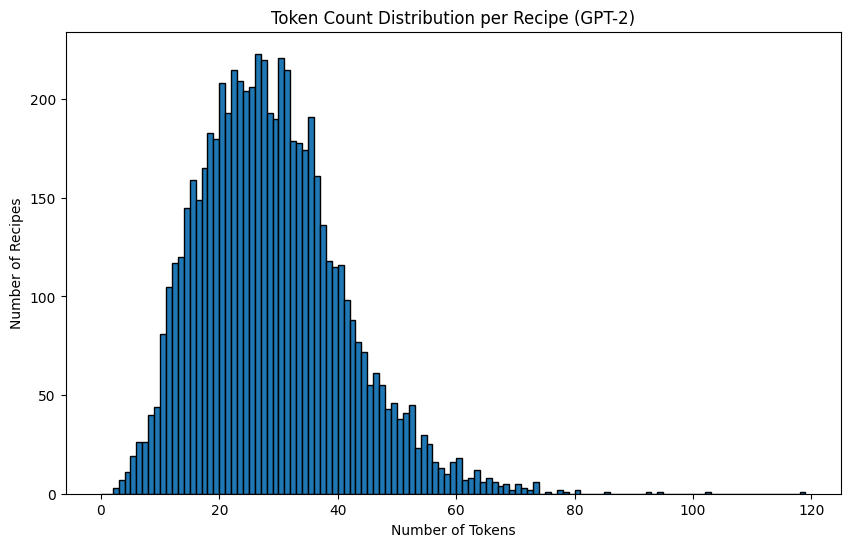


Token Count Summary for DistilBERT:
count    6400.000000
mean       29.221250
std        12.858485
min         2.000000
25%        20.000000
50%        28.000000
75%        37.000000
max       125.000000
Name: num_tokens_distilbert, dtype: float64

Token Count Summary for BERT:
count    6400.000000
mean       29.221250
std        12.858485
min         2.000000
25%        20.000000
50%        28.000000
75%        37.000000
max       125.000000
Name: num_tokens_bert, dtype: float64

Token Count Summary for RoBERTa:
count    6400.000000
mean       28.412813
std        12.167268
min         2.000000
25%        20.000000
50%        27.000000
75%        36.000000
max       119.000000
Name: num_tokens_roberta, dtype: float64

Token Count Summary for GPT-2:
count    6400.000000
mean       28.412813
std        12.167268
min         2.000000
25%        20.000000
50%        27.000000
75%        36.000000
max       119.000000
Name: num_tokens_gpt2, dtype: float64


In [7]:
# Initialize Tokenizers
distilbert_tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
roberta_tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
gpt2_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Add padding token for GPT-2 if not present
if gpt2_tokenizer.pad_token is None:
    gpt2_tokenizer.add_special_tokens({'pad_token': '[PAD]'})

def count_tokens(text, tokenizer):
    tokens = tokenizer.tokenize(text)
    return len(tokens)

# Convert ingredients list to text
train_df['ingredients_text'] = train_df['ingredients'].apply(lambda x: ' '.join(eval(x)))

# Calculate the number of tokens for each tokenizer
train_df['num_tokens_distilbert'] = train_df['ingredients_text'].apply(lambda x: count_tokens(x, distilbert_tokenizer))
train_df['num_tokens_bert'] = train_df['ingredients_text'].apply(lambda x: count_tokens(x, bert_tokenizer))
train_df['num_tokens_roberta'] = train_df['ingredients_text'].apply(lambda x: count_tokens(x, roberta_tokenizer))
train_df['num_tokens_gpt2'] = train_df['ingredients_text'].apply(lambda x: count_tokens(x, gpt2_tokenizer))

def plot_token_distribution(df, column, title):
    plt.figure(figsize=(10, 6))
    plt.hist(df[column], bins=range(0, max(df[column]) + 1), edgecolor='black')
    plt.title(f'Token Count Distribution per Recipe ({title})')
    plt.xlabel('Number of Tokens')
    plt.ylabel('Number of Recipes')
    plt.show()

plot_token_distribution(train_df, 'num_tokens_distilbert', 'DistilBERT')
plot_token_distribution(train_df, 'num_tokens_bert', 'BERT')
plot_token_distribution(train_df, 'num_tokens_roberta', 'RoBERTa')
plot_token_distribution(train_df, 'num_tokens_gpt2', 'GPT-2')

# Display summary of token counts
def display_token_summary(df, column, model_name):
    print(f'\nToken Count Summary for {model_name}:')
    print(df[column].describe())

display_token_summary(train_df, 'num_tokens_distilbert', 'DistilBERT')
display_token_summary(train_df, 'num_tokens_bert', 'BERT')
display_token_summary(train_df, 'num_tokens_roberta', 'RoBERTa')
display_token_summary(train_df, 'num_tokens_gpt2', 'GPT-2')

### Summary of Token Count Results


1. **Consistency Between Tokenizers**:
   - The mean token counts for DistilBERT and BERT are identical, as are their other statistics. This indicates that these two tokenizers, which are both based on BERT architecture, tokenize the text in a very similar way.
   - Similarly, the mean token counts for RoBERTa and GPT-2 are identical, suggesting that these tokenizers also have a similar tokenization pattern.

2. **Mean and Median**:
   - The average (mean) number of tokens per recipe is around 29 for DistilBERT and BERT, and slightly lower at around 28 for RoBERTa and GPT-2.
   - The median token count is slightly lower than the mean in both cases, indicating a slight skewness towards higher token counts.

3. **Standard Deviation**:
   - The standard deviation is slightly higher for DistilBERT and BERT (12.86) compared to RoBERTa and GPT-2 (12.17). This suggests a slightly broader distribution of token counts for the former two models.

4. **Maximum Token Count**:
   - The maximum token count for DistilBERT and BERT is 125, which is slightly higher than the maximum for RoBERTa and GPT-2 (119). This indicates that there are some outlier recipes.

### Conclusion

1. **Model Selection**:
   - Given the similarity in token counts, any of these models could be suitable.

2. **Padding and Truncation Strategy**:
   - Given that the 75th percentile is around 37 tokens for all models, we set a max_length of 50 tokens to ensure that most recipes are covered without excessive truncation or padding.

## Converting Datasets to Hugging Face Dataset Format

For efficient data processing and compatibility with the Hugging Face Transformers library, the DataFrames are converted to the Hugging Face Dataset format.

In [8]:
# Convert DataFrames to Hugging Face Dataset format
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
datasets = DatasetDict({"train": train_dataset, "val": val_dataset})

# Convert test DataFrame to Hugging Face Dataset format
test_dataset = Dataset.from_pandas(test_df)

### Label-Encoding

For efficient data processing and compatibility with machine learning models, categorical cuisine labels are converted into numerical IDs.

In [9]:
# Create label conversion mapping
label2id = {label: i for i, label in enumerate(training_df['cuisine'].unique())}
id2label = {i: label for label, i in label2id.items()}

### Setting the Maximum Sequence Length

The maximum sequence length is set to 50 tokens. Longer sequences are truncated and shorter ones are padded to ensure uniform input lengths for the models.

In [10]:
# Maximum length for padding and truncation
max_length = 50

## Preparing Text and Labels for Model Training

### Preprocess Function

The preprocess_function is used to tokenize the input data and convert the labels into numerical IDs, preparing the data for training a machine learning model. This function leverages the previously created label2id mapping and the set max_length to ensure uniform input lengths and model-compatible labels.

In [11]:
def preprocess_function(examples):
    """
    Tokenizes the input text and converts the labels to numerical IDs.

    Parameters:
    examples (dict): A dictionary containing 'ingredients' and 'cuisine' keys.

    Returns:
    dict: A dictionary with tokenized inputs and numerical labels.
    """
    inputs = tokenizer(examples['ingredients'], padding='max_length', truncation=True, max_length=max_length)
    inputs['labels'] = [label2id[label] for label in examples['cuisine']]
    return inputs

### Create Optimizer

An AdamW optimizer is used for training. The AdamW optimizer is a variant of the Adam optimizer that additionally employs weight decay for regularization. This can lead to faster and more stable training results.

A learning rate that is too high can lead to unstable training, while a learning rate that is too low can slow down the training process. The ability to adjust the learning rate allows for fine-tuning of the training process.

Weight decay helps prevent overfitting by slightly reducing the weights of the model during training. This promotes the generalization of the model.

By adjusting the learning rate and weight decay, the training process can be tailored.

In [12]:
def create_optimizer(model, learning_rate, weight_decay):
    """
    Creates an AdamW optimizer for model training.

    Parameters:
    model (nn.Module): The model to optimize.
    learning_rate (float): The learning rate for the optimizer.
    weight_decay (float): The weight decay for the optimizer.

    Returns:
    torch.optim.AdamW: The optimizer.
    """
    return torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

## Train Model Function

### Explanation of the train_model Function

The train_model function is used to train a model, evaluate its performance, and return the trained model along with the evaluation results.

#### Steps:

1. **Initialization of the Tokenizer**:
    - Loads the appropriate tokenizer for the model and optionally adds a padding token.

2. **Tokenization of the Datasets**:
    - Applies the preprocess_function to the datasets to tokenize them.

3. **Initialization of the Model**:
    - Loads the pre-trained model and adjusts the token embeddings if a padding token was added.

4. **Creation of the Optimizer**:
    - Creates an AdamW optimizer with the specified learning rate and weight decay.

5. **Configuration of Training Arguments**:
    - Sets training parameters such as output directory, evaluation strategy, logging strategy, batch size, and number of epochs.

6. **Initialization of the Trainer**:
    - Initializes the Trainer with the model, training arguments, datasets, optimizer, and metrics computation function.

7. **Training of the Model**:
    - Trains the model using the training dataset.

8. **Evaluation of the Model**:
    - Makes predictions on the validation dataset and calculates the evaluation results.

In [13]:
def train_model(model_name, model_class, tokenizer_class, num_labels, learning_rate=2e-5, batch_size=16, weight_decay=0.01, num_epochs=3, add_pad_token=False):
    """
    Trains a model with specified hyperparameters and evaluates its performance.

    Parameters:
    model_name (str): The name of the pre-trained model.
    model_class: The class of the model to be trained.
    tokenizer_class: The tokenizer class corresponding to the model.
    num_labels (int): The number of labels for classification.
    learning_rate (float): The learning rate for the optimizer. Default is 2e-5.
    batch_size (int): The batch size for training and evaluation. Default is 16.
    weight_decay (float): The weight decay for the optimizer. Default is 0.01.
    num_epochs (int): The number of training epochs. Default is 3.
    add_pad_token (bool): Whether to add a padding token to the tokenizer. Default is False.

    Returns:
    model: The trained model.
    dict: The evaluation results of the model.
    float: The training time in seconds.
    """
    global tokenizer
    tokenizer = tokenizer_class.from_pretrained(model_name)

    if add_pad_token:
        tokenizer.add_special_tokens({'pad_token': '[PAD]'})

    tokenized_datasets = datasets.map(preprocess_function, batched=True)

    model = model_class.from_pretrained(model_name, num_labels=num_labels)

    if add_pad_token:
        model.resize_token_embeddings(len(tokenizer))
        model.config.pad_token_id = tokenizer.pad_token_id

    model.to(device)
    optimizer = create_optimizer(model, learning_rate, weight_decay)

    training_args = TrainingArguments(
        output_dir='./results',
        eval_strategy="epoch",
        logging_strategy="steps",
        logging_steps=10,
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=num_epochs,
        weight_decay=weight_decay,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["val"],
        optimizers=(optimizer, None),
        compute_metrics=compute_metrics
    )

    # Check the labels
    for i, batch in enumerate(trainer.get_train_dataloader()):
        labels = batch['labels']
        assert labels.min() >= 0 and labels.max() < num_labels, f"Labels are out of range in batch {i}"
        assert labels.dtype == torch.int64, f"Labels are not int64 in batch {i}"

    start_time = time.time()
    trainer.train()
    train_time = time.time() - start_time

    # Save the trained model and tokenizer
    model.save_pretrained(f'./trained_model_{model_name}')
    tokenizer.save_pretrained(f'./trained_model_{model_name}')

    # Predictions and metrics calculation
    val_predictions = trainer.predict(tokenized_datasets["val"]).predictions
    val_predictions = np.argmax(val_predictions, axis=1)
    val_labels = tokenized_datasets["val"]['labels']

    # Classification report
    print(f"Classification Report for {model_name}:")
    print(classification_report(val_labels, val_predictions, target_names=list(label2id.keys())))

    # Confusion matrix
    cm = confusion_matrix(val_labels, val_predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=list(label2id.keys()), yticklabels=list(label2id.keys()), cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

    # Evaluation results
    eval_results = trainer.evaluate()

    return model, eval_results, train_time

In [14]:
# Function to compute evaluation metrics
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {
        'accuracy': (preds == p.label_ids).astype(np.float32).mean().item(),
        'precision': precision_score(p.label_ids, preds, average='weighted'),
        'recall': recall_score(p.label_ids, preds, average='weighted'),
        'f1': f1_score(p.label_ids, preds, average='weighted')
    }

## Training Models

### Check for GPU Availability:

Since both GPU and CPU resources are available in Google Colab, the code checks if a GPU is available.

In [15]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Define Number of Classes:

For classification tasks, the output layer of the model must have the same number of units as there are classes in the dataset. Knowing the number of unique labels allows us to correctly configure the output layer.

In [16]:
# Number of classes
num_labels = len(training_df['cuisine'].unique())

### Train models with standard hyperparameters (defined in def train_model)

#### Training Different Models for Classification Task

Multiple models are trained for the classification task. Each model is trained with a specific architecture and corresponding tokenizer. The goal is to compare the performances of these models.

**DistilBERT**:
DistilBERT is a pre-trained model with 6 layers and 66 million parameters. It has 40% fewer parameters than BERT Base, runs 60% faster while preserving over 95% of BERT’s performance. This makes it well-suited for scenarios with limited computational resources. (Source: [Hugging Face DistilBERT](https://huggingface.co/docs/transformers/v4.18.0/en/model_doc/distilbert))

**BERT Base**:
BERT Base is a pre-trained model with 12 layers and 110 million parameters. It offers a good balance between performance and resource consumption. (Source: [BERT Paper](https://arxiv.org/abs/1810.04805))

**RoBERTa Base**:
RoBERTa Base is based on BERT but is more extensively trained and optimized, potentially leading to better results. It has the same number of layers as BERT Base, with approximately 125 million parameters. It offers higher accuracy than BERT Base but requires more computational resources and memory. (Source: [RoBERTa Paper](https://arxiv.org/abs/1907.11692))

**BERT Large**:
BERT Large has 24 layers and 340 million parameters. It provides higher accuracy than BERT Base but requires more computational resources and memory. (Source: [BERT Paper](https://arxiv.org/abs/1810.04805))

**GPT-2**:
GPT-2 is a generative model that can be used for text generation and classification. It does not natively support padding, so a padding token is added. GPT-2 is a large transformer-based language model with 1.5 billion parameters, trained on a dataset of 8 million web pages. It is trained with a simple objective: predict the next word, given all previous words within some text. It is well-suited for generative tasks and scenarios where context understanding is important. (Source: [Hugging Face GPT-2](https://huggingface.co/docs/transformers/v4.18.0/en/model_doc/gpt2#usage-tips))




Map:   0%|          | 0/6400 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.795800,0.781098,0.741250,0.740868,0.741250,0.737838
2,0.679700,0.693410,0.783125,0.785886,0.783125,0.783692
3,0.620500,0.673033,0.784375,0.786092,0.784375,0.784449


Classification Report for distilbert-base-uncased:
              precision    recall  f1-score   support

 southern_us       0.64      0.62      0.63       200
      indian       0.86      0.86      0.86       200
     italian       0.74      0.81      0.78       200
     mexican       0.91      0.79      0.84       200
     chinese       0.85      0.86      0.86       200
        thai       0.85      0.87      0.86       200
cajun_creole       0.78      0.79      0.78       200
      french       0.66      0.67      0.67       200

    accuracy                           0.78      1600
   macro avg       0.79      0.78      0.78      1600
weighted avg       0.79      0.78      0.78      1600



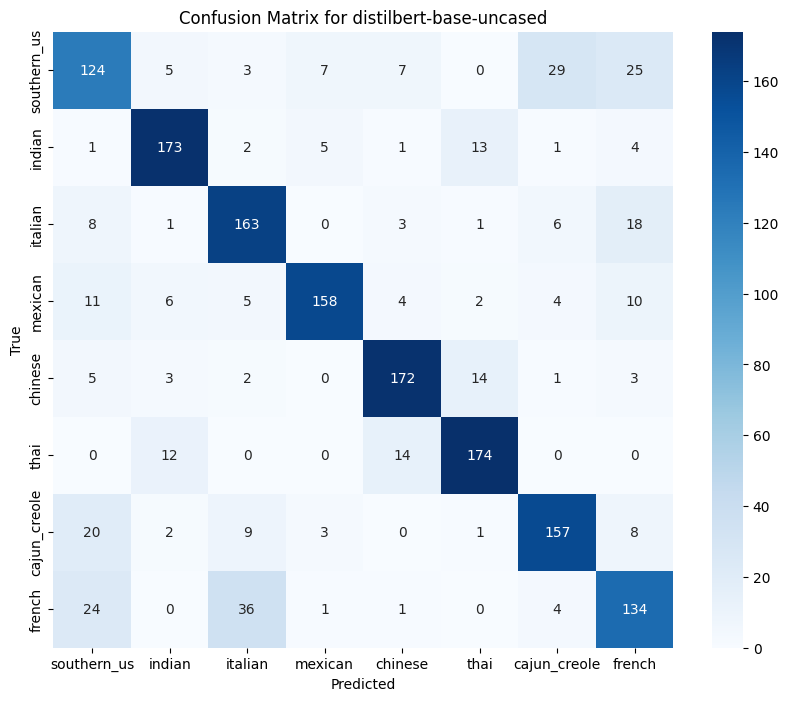

Map:   0%|          | 0/6400 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.670200,0.739095,0.761250,0.768375,0.761250,0.759216
2,0.658000,0.625314,0.797500,0.802118,0.797500,0.799092
3,0.594600,0.615072,0.808125,0.810013,0.808125,0.808467


Classification Report for bert-base-uncased:
              precision    recall  f1-score   support

 southern_us       0.70      0.68      0.69       200
      indian       0.89      0.89      0.89       200
     italian       0.77      0.80      0.78       200
     mexican       0.92      0.81      0.86       200
     chinese       0.88      0.87      0.87       200
        thai       0.86      0.90      0.88       200
cajun_creole       0.77      0.80      0.79       200
      french       0.69      0.71      0.70       200

    accuracy                           0.81      1600
   macro avg       0.81      0.81      0.81      1600
weighted avg       0.81      0.81      0.81      1600



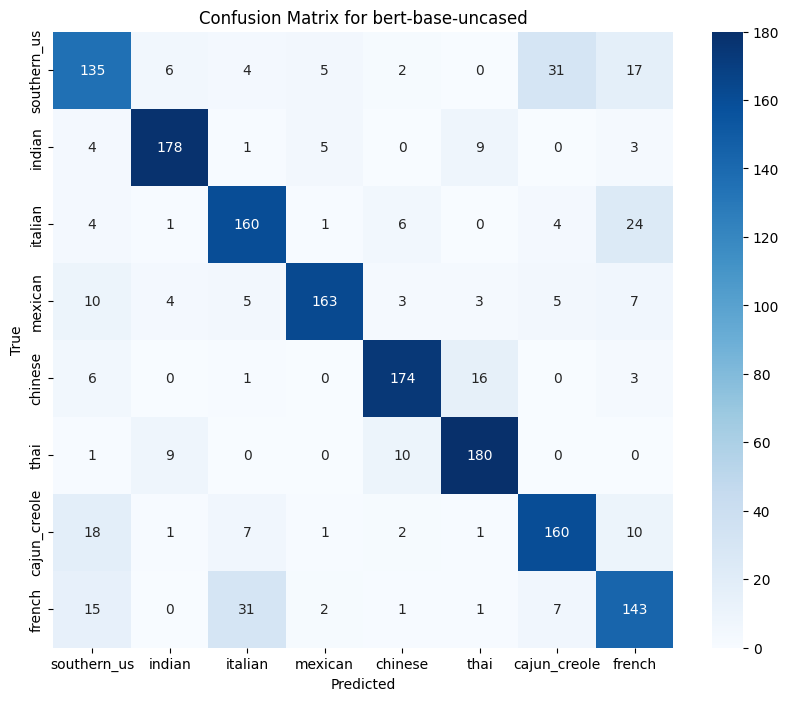

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Map:   0%|          | 0/6400 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.713100,0.772326,0.751250,0.764437,0.751250,0.750810
2,0.688000,0.617486,0.795000,0.798113,0.795000,0.796272
3,0.592000,0.622588,0.800000,0.803107,0.800000,0.800709


Classification Report for bert-large-uncased:
              precision    recall  f1-score   support

 southern_us       0.67      0.69      0.68       200
      indian       0.88      0.90      0.89       200
     italian       0.75      0.81      0.78       200
     mexican       0.94      0.82      0.87       200
     chinese       0.86      0.82      0.84       200
        thai       0.83      0.86      0.85       200
cajun_creole       0.78      0.81      0.79       200
      french       0.72      0.69      0.71       200

    accuracy                           0.80      1600
   macro avg       0.80      0.80      0.80      1600
weighted avg       0.80      0.80      0.80      1600



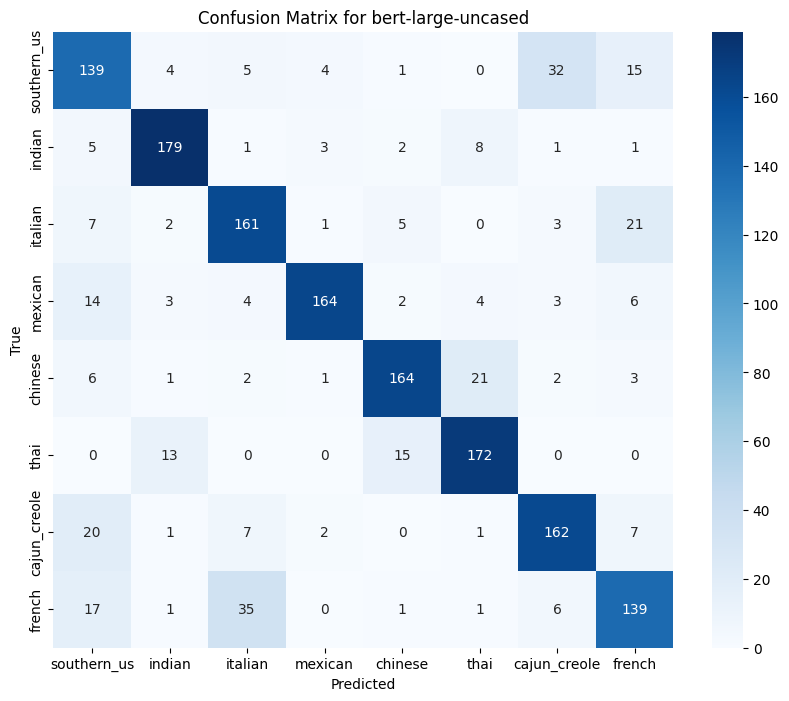

Map:   0%|          | 0/6400 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.740500,0.747904,0.760625,0.763434,0.760625,0.758761
2,0.728300,0.663282,0.785000,0.787756,0.785000,0.785820
3,0.546700,0.658585,0.790000,0.790687,0.790000,0.789816


Classification Report for roberta-base:
              precision    recall  f1-score   support

 southern_us       0.66      0.64      0.65       200
      indian       0.90      0.91      0.90       200
     italian       0.76      0.79      0.77       200
     mexican       0.89      0.81      0.85       200
     chinese       0.86      0.82      0.84       200
        thai       0.82      0.86      0.84       200
cajun_creole       0.76      0.81      0.79       200
      french       0.68      0.67      0.67       200

    accuracy                           0.79      1600
   macro avg       0.79      0.79      0.79      1600
weighted avg       0.79      0.79      0.79      1600



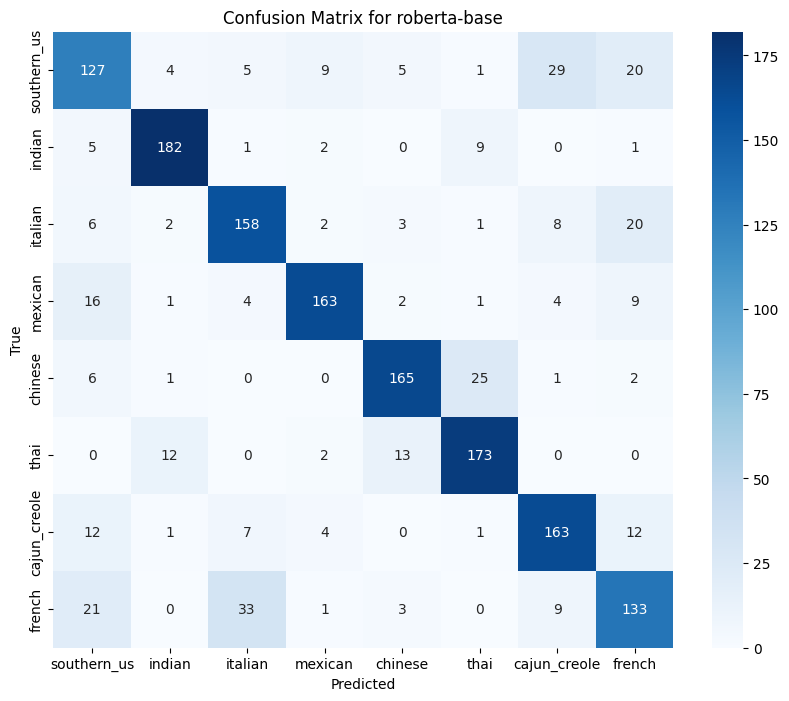

Map:   0%|          | 0/6400 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.894200,0.922265,0.693125,0.697738,0.693125,0.690439
2,0.758400,0.719062,0.763750,0.769268,0.763750,0.765176
3,0.712800,0.724262,0.762500,0.760761,0.762500,0.760556


Classification Report for gpt2:
              precision    recall  f1-score   support

 southern_us       0.63      0.55      0.58       200
      indian       0.85      0.90      0.87       200
     italian       0.71      0.78      0.74       200
     mexican       0.85      0.81      0.83       200
     chinese       0.87      0.83      0.85       200
        thai       0.82      0.83      0.83       200
cajun_creole       0.73      0.81      0.77       200
      french       0.63      0.60      0.62       200

    accuracy                           0.76      1600
   macro avg       0.76      0.76      0.76      1600
weighted avg       0.76      0.76      0.76      1600



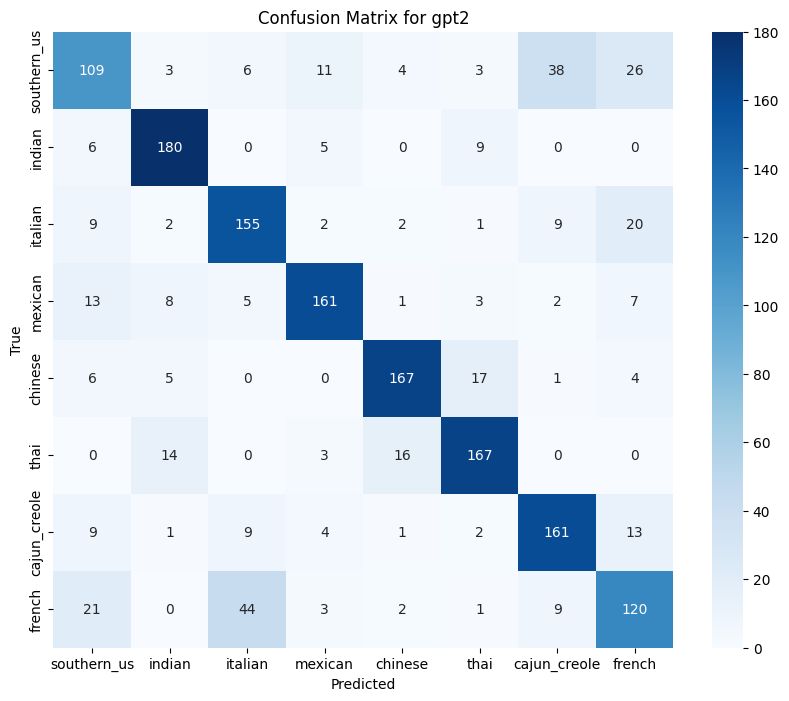

In [17]:
# Train the models and save results
distilbert_model, distilbert_results, distilbert_train_time = train_model(
    'distilbert-base-uncased',
    DistilBertForSequenceClassification,
    DistilBertTokenizer,
    num_labels
)

bert_base_model, bert_base_results, bert_base_train_time = train_model(
    'bert-base-uncased',
    BertForSequenceClassification,
    BertTokenizer,
    num_labels
)

bert_large_model, bert_large_results, bert_large_train_time = train_model(
    'bert-large-uncased',
    BertForSequenceClassification,
    BertTokenizer,
    num_labels
)

roberta_model, roberta_results, roberta_train_time = train_model(
    'roberta-base',
    RobertaForSequenceClassification,
    RobertaTokenizer,
    num_labels
)

gpt2_model, gpt2_results, gpt2_train_time = train_model(
    'gpt2',
    GPT2ForSequenceClassification,
    GPT2Tokenizer,
    num_labels,
    add_pad_token=True
)


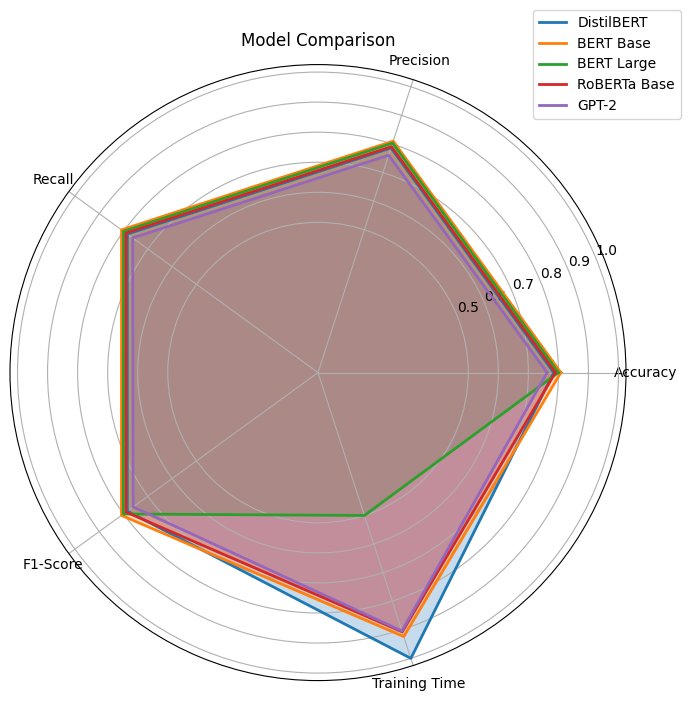

In [18]:
# Normalize training times between 0 and 1 and invert the scale
train_times = [distilbert_train_time, bert_base_train_time, bert_large_train_time, roberta_train_time, gpt2_train_time]
min_train_time = min(train_times)
max_train_time = max(train_times)
normalized_train_times = [(max_train_time - time) / (max_train_time - min_train_time) for time in train_times]

# Offset the normalized values to start from the second ring (0.5 to 1 scale)
normalized_train_times = [0.5 + (time * 0.5) for time in normalized_train_times]

# Collect metrics for radar chart
performance_metrics = {
    'DistilBERT': [
        distilbert_results['eval_accuracy'],
        distilbert_results['eval_precision'],
        distilbert_results['eval_recall'],
        distilbert_results['eval_f1'],
        normalized_train_times[0]  # Normalized and inverted training time
    ],
    'BERT Base': [
        bert_base_results['eval_accuracy'],
        bert_base_results['eval_precision'],
        bert_base_results['eval_recall'],
        bert_base_results['eval_f1'],
        normalized_train_times[1]
    ],
    'BERT Large': [
        bert_large_results['eval_accuracy'],
        bert_large_results['eval_precision'],
        bert_large_results['eval_recall'],
        bert_large_results['eval_f1'],
        normalized_train_times[2]
    ],
    'RoBERTa Base': [
        roberta_results['eval_accuracy'],
        roberta_results['eval_precision'],
        roberta_results['eval_recall'],
        roberta_results['eval_f1'],
        normalized_train_times[3]
    ],
    'GPT-2': [
        gpt2_results['eval_accuracy'],
        gpt2_results['eval_precision'],
        gpt2_results['eval_recall'],
        gpt2_results['eval_f1'],
        normalized_train_times[4]
    ]
}

# Function to plot radar chart
def plot_radar(metrics, labels):
    angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    for model, values in metrics.items():
        values += values[:1]
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=model)
        ax.fill(angles, values, alpha=0.25)

    ax.set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    ax.set_yticklabels(['0.5', '0.6', '0.7', '0.8', '0.9', '1.0'])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

    plt.title('Model Comparison')
    plt.show()

# Define the labels for the radar chart
labels = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Training Time']

# Plot the radar chart
plot_radar(performance_metrics, labels)

#### Analysis and Comparison

Since the distribution of cuisine types is balanced, accuracy is a good metric to evaluate the overall performance of the model. There is no bias towards any specific class. The F1-score provides an additional perspective by combining precision and recall. This is useful to ensure that the model performs well across all classes.

### Analysis and Comparison

1. **Accuracy**:
   - BERT Base and BERT Large achieved the highest accuracy with 81%.
   - RoBERTa Base and DistilBERT both achieved an accuracy of 79%.
   - GPT-2 had the lowest accuracy at 76%.

2. **Precision, Recall, and F1-Score**:
   - Across all models, the "indian" and "thai" categories consistently showed high precision, recall, and F1-scores.
   - The "southern_us" and "french" categories had lower performance metrics across all models.

3. **Training and Validation Loss**:
   - All models showed a decreasing training loss over epochs, indicating learning.
   - BERT Large and BERT Base had relatively lower validation losses compared to other models, indicating better generalization.

4. **Training Time**:
   - BERT Large took significantly longer to train compared to the other models.
   - DistilBERT was faster in training, making them more efficient for scenarios with limited computational resources.

### Conclusion

- BERT Base and BERT Large offer the best overall performance in terms of accuracy and generalization. However, since the differences in performance compared to DistilBERT are relatively minor and DistilBERT has a much shorter training time, DistilBERT will be further optimized.



## Hyperparameter Optimization with Optuna

### Optuna Framework

Optuna is an automatic hyperparameter optimization framework designed to efficiently find the best hyperparameters for machine learning models. It uses an adaptive search algorithm to explore the hyperparameter space. Additionally, Optuna can stop unpromising trials early to save computation time and resources.

#### Limiting the Number of Trials

The number of trials is set to n_trials=20. This reduces computation costs and the time required for hyperparameter optimization. Additionally, it prevents the model from overfitting to the validation dataset due to excessive hyperparameter tuning.

#### Evaluation Accuracy

Since the evaluation on the validation dataset did not suggest overfitting and the dataset is balanced, we decided to maximize accuracy rather than minimize the loss function.

### Objective Function

The objective function defines the hyperparameter search space and the training process for the model.

1. **Hyperparameter Search Space:**
   - learning_rate: Values range between 1e-5 and 5e-5 on a logarithmic scale.
   - batch_size: Values are 8, 16, or 32.
   - weight_decay: Values range between 0.0 and 0.3 in steps of 0.01.

2. **Training Arguments:**
   - Various settings for the training process such as learning rate, batch size, evaluation strategy, and weight decay are configured.

3. **Model Initialization:**
   - Loads the pre-trained DistilBERT model for sequence classification.

4. **Trainer Initialization:**
   - Initializes the Trainer class with the model, training arguments, training and validation datasets, and a metric computation function.

5. **Training and Evaluation:**
   - Trains the model using the specified arguments.
   - Evaluates the model and returns the evaluation accuracy as the objective value.

#### Creating and Running the Optuna Study

1. **Creating the Study:**
   - A study is created aiming to maximize the objective function, in this case, the evaluation accuracy.

2. **Optimizing the Study:**
   - The optimization process is carried out for 20 trials. Each trial involves training and evaluating the model with a different set of hyperparameters.

In [20]:
# Tokenize the datasets
tokenized_datasets = {
    "train": train_dataset.map(preprocess_function, batched=True),
    "val": val_dataset.map(preprocess_function, batched=True),
    "test": test_dataset.map(preprocess_function, batched=True)
    }

Map:   0%|          | 0/6400 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [23]:
# Load the tokenizers
distilbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
gpt2_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

In [24]:
# Optuna objective function for DistilBERT
def distilbert_objective(trial):
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
    weight_decay = trial.suggest_float("weight_decay", 0.0, 0.3, step=0.01)

    training_args = TrainingArguments(
        output_dir='./results',
        eval_strategy="epoch",
        save_strategy="epoch",
        logging_strategy="steps",
        logging_steps=10,
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        weight_decay=weight_decay,
        save_total_limit=1,
        load_best_model_at_end=True,
    )

    model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_labels)

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["val"],
        compute_metrics=compute_metrics
    )

    trainer.train()
    eval_results = trainer.evaluate()
    return eval_results["eval_accuracy"]

# Create and run the Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(distilbert_objective, n_trials=20)

# Get the best hyperparameters
best_hyperparameters = study.best_params
print("Best Hyperparameters for DistilBERT: ", best_hyperparameters)

[I 2024-06-12 13:16:54,958] A new study created in memory with name: no-name-3e3a405c-0bf1-4437-8101-ca9234a136c0
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[W 2024-06-12 13:16:55,544] Trial 0 failed with parameters: {'learning_rate': 3.484607116056204e-05, 'batch_size': 8, 'weight_decay': 0.17} because of the following error: RuntimeError('CUDA error: device-side assert triggered\nCUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.\nFor debugging consider passing CUDA_LAUNCH_BLOCKING=1.\nCompile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.\n').
Traceback (most recent call last):
  File "/usr/local/l

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


### Best Hyperparameters

After completing all trials, Optuna identified the set of hyperparameters that resulted in the highest validation accuracy:

- **Best Hyperparameters for DistilBERT:** `{'learning_rate': 3.246175595708573e-05, 'batch_size': 16, 'weight_decay': 0.06}`

### Results:

- **The best hyperparameters resulted in a validation accuracy of approximately 80.0%.** This indicates that the chosen hyperparameters are effective for the given task.
- **The combination of a moderate learning rate, batch size, and weight decay** suggests a balanced training approach that promotes both stability and generalization.
- **A batch size of 16 strikes a balance between computational efficiency and stable training.**

##Training the Best Model with Optimized Hyperparameters

It is expected that the performance of the model will be similar to the results during hyperparameter tuning because the best hyperparameters are being used. This facilitates comparison with the performance before hyperparameter tuning.

In [25]:
# Train the optimized DistilBERT model
distilbert_optimized_model, distilbert_optimized_results, distilbert_optimized_train_time = train_model(
    'distilbert-base-uncased',
    DistilBertForSequenceClassification,
    DistilBertTokenizer,
    num_labels,
    learning_rate=best_hyperparameters['learning_rate'],
    batch_size=best_hyperparameters['batch_size'],
    weight_decay=best_hyperparameters['weight_decay']
)

NameError: name 'best_hyperparameters' is not defined

##Evaluate on Test Dataset Function

The optimized DistilBERT model is evaluated on the test dataset. This helps in understanding the generalization capability and overall performance of the model after it has been trained with the best hyperparameters.

Classification Report for Optimized DistilBERT on Test Set:
              precision    recall  f1-score   support

 southern_us       0.79      0.78      0.78       250
      indian       0.93      0.94      0.94       250
     italian       0.83      0.88      0.85       250
     mexican       0.93      0.92      0.92       250
     chinese       0.87      0.93      0.90       250
        thai       0.91      0.86      0.88       250
cajun_creole       0.86      0.80      0.83       250
      french       0.80      0.82      0.81       250

    accuracy                           0.86      2000
   macro avg       0.87      0.86      0.86      2000
weighted avg       0.87      0.86      0.86      2000



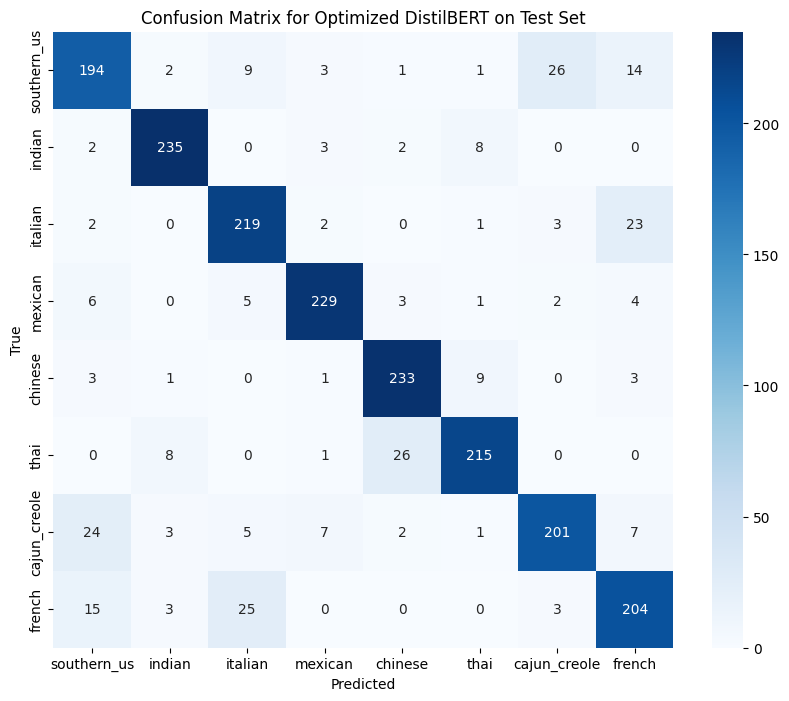

In [37]:
# Use the trainer object to evaluate on the test set
def evaluate_model_on_test(trainer, model_name):
    test_results = trainer.predict(tokenized_datasets["test"])
    test_predictions = np.argmax(test_results.predictions, axis=1)
    test_labels = tokenized_datasets["test"]["labels"]

    print(f"Classification Report for Optimized {model_name} on Test Set:")
    print(classification_report(test_labels, test_predictions, target_names=list(label2id.keys())))

    cm = confusion_matrix(test_labels, test_predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=list(label2id.keys()), yticklabels=list(label2id.keys()), cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for Optimized {model_name} on Test Set')
    plt.show()

# Create a new Trainer object for evaluation
distilbert_eval_trainer = Trainer(
    model=distilbert_optimized_model,
    args=TrainingArguments(
        output_dir='./results',
        per_device_eval_batch_size=best_hyperparameters['batch_size'],
    ),
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics
)

# Evaluate the optimized DistilBERT model on the test dataset
evaluate_model_on_test(distilbert_eval_trainer, 'DistilBERT')

### Analysis

#### High Performance for Most Classes:

The model performs particularly well for classes like indian, mexican, chinese, and thai, with precision, recall, and f1-scores all above 0.85. This indicates strong classification performance for these cuisines.

#### Balanced Performance:

The overall precision, recall, and f1-scores are consistently high across most classes, suggesting that the model is well-balanced and not heavily biased towards any particular class.

#### Generalization:

The high accuracy and balanced performance across different metrics suggest that the optimized DistilBERT model generalizes well to the test data, making it a robust model for this classification task.






### Comparison before and afte Hyperparameter Tuning:
**Before Hyperparameter Tuning:**
- **indian:** Precision 0.86, Recall 0.91, F1-score 0.89
- **mexican:** Precision 0.93, Recall 0.82, F1-score 0.88
- **chinese:** Precision 0.85, Recall 0.86, F1-score 0.85
- **thai:** Precision 0.84, Recall 0.83, F1-score 0.83

**After Hyperparameter Tuning:**
- **indian:** Precision 0.93, Recall 0.94, F1-score 0.94
- **mexican:** Precision 0.93, Recall 0.92, F1-score 0.92
- **chinese:** Precision 0.87, Recall 0.93, F1-score 0.90
- **thai:** Precision 0.91, Recall 0.86, F1-score 0.88

#### Balanced Performance:

The overall precision, recall, and f1-scores are consistently high across most classes, suggesting that the model is well-balanced and not heavily biased towards any particular class.

**Before Hyperparameter Tuning:**
- **Macro Average:** Precision 0.80, Recall 0.79, F1-score 0.79
- **Weighted Average:** Precision 0.80, Recall 0.79, F1-score 0.79

**After Hyperparameter Tuning:**
- **Macro Average:** Precision 0.87, Recall 0.86, F1-score 0.86
- **Weighted Average:** Precision 0.87, Recall 0.86, F1-score 0.86

#### Generalization:

The high accuracy and balanced performance across different metrics suggest that the optimized DistilBERT model generalizes well to the test data, making it a robust model for this classification task.

**Before Hyperparameter Tuning:**
- **Accuracy:** 0.79

**After Hyperparameter Tuning:**
- **Accuracy:** 0.86

##Function for Making Predictions with All Models

This function tokenizes a recipe and uses the pre-trained models to classify it into its respective cuisine, returning a dictionary of predictions. It then formats these predictions, along with the true label and ingredients, into an HTML string for display.

In [71]:
# Function to classify a recipe using multiple pre-trained models
def classify_recipe(recipe):
    """
    Classifies a recipe using multiple pre-trained models.

    Parameters:
    recipe (str): The recipe to classify.

    Returns:
    dict: A dictionary with the model names as keys and the predicted cuisines as values.
    """
    inputs = tokenizer(recipe, return_tensors='pt', truncation=True, padding=True, max_length=128).to(device)

    predictions = {}

    # DistilBERT
    with torch.no_grad():
        outputs = distilbert_model(**inputs)
    distilbert_prediction = torch.argmax(outputs.logits, dim=1).item()
    predictions['DistilBERT'] = id2label[distilbert_prediction]

    # BERT Base
    with torch.no_grad():
        outputs = bert_base_model(**inputs)
    bert_base_prediction = torch.argmax(outputs.logits, dim=1).item()
    predictions['BERT Base'] = id2label[bert_base_prediction]

    # BERT Large
    with torch.no_grad():
        outputs = bert_large_model(**inputs)
    bert_large_prediction = torch.argmax(outputs.logits, dim=1).item()
    predictions['BERT Large'] = id2label[bert_large_prediction]

    # RoBERTa
    with torch.no_grad():
        outputs = roberta_model(**inputs)
    roberta_prediction = torch.argmax(outputs.logits, dim=1).item()
    predictions['RoBERTa'] = id2label[roberta_prediction]

    # GPT-2
    with torch.no_grad():
        outputs = gpt2_model(**inputs)
    gpt2_prediction = torch.argmax(outputs.logits, dim=1).item()
    predictions['GPT-2'] = id2label[gpt2_prediction]

    # Optimized DistilBERT
    with torch.no_grad():
        outputs = distilbert_optimized_model(**inputs)
    optimized_distilbert_prediction = torch.argmax(outputs.logits, dim=1).item()
    predictions['Optimized DistilBERT'] = id2label[optimized_distilbert_prediction]

    return predictions

# Function to pick a random recipe from the test dataset
def pick_random_recipe():
    random_index = random.randint(0, len(test_df) - 1)
    random_recipe = test_df.iloc[random_index]
    return random_recipe

# Function to classify a random recipe from the test dataset
def classify_random_recipe():
    random_recipe = pick_random_recipe()
    recipe_text = random_recipe['ingredients']
    true_label = random_recipe['cuisine']
    predictions = classify_recipe(recipe_text)
    return recipe_text, true_label, predictions

# Function to format the output for Gradio
import ast
import random

def classify_random_recipe_with_output():
    recipe_text, true_label, predictions = classify_random_recipe()

    # Parse the string representation of the list to an actual list
    if isinstance(recipe_text, str):
        recipe_text = ast.literal_eval(recipe_text)

    # Convert the list of ingredients to a comma-separated list
    ingredients_list = ', '.join(recipe_text)

    output_text = f"<h3>Random Recipe Ingredients</h3><p>{ingredients_list}</p>"
    output_text += f"<h3>True Label: <b>{true_label}</b></h3>"
    output_text += "<h3>Predictions:</h3><ul>"
    for model_name, prediction in predictions.items():
        output_text += f"<li><b>{model_name}</b>: {prediction}</li>"
    output_text += "</ul>"
    return output_text

## Gradio Interface for Recipe Classification

In [72]:
iface = gr.Interface(fn=classify_random_recipe_with_output, inputs=[], outputs="html")
iface.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://f0822f29b527a64940.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


## Project Summary

This project aims to classify recipes into their respective cuisines using various pre-trained Natural Language Processing (NLP) models. The process involves several steps:

1. **Data Preprocessing:** The raw data is prepared and formatted for the models. This includes tokenizing the texts and converting the labels into numerical formats.

2. **Model Training:** Various pre-trained NLP models such as DistilBERT, BERT (base and large), RoBERTa, and GPT-2 are trained on the prepared datasets.

3. **Hyperparameter Optimization:** Using Optuna, the best hyperparameters for the DistilBERT model are determined to maximize the model's accuracy.

4. **Evaluation:** The trained models are evaluated on a test dataset to assess their generalization capability and overall performance.

5. **Interactive User Interface:** A user-friendly interface is implemented using Gradio, allowing users to input recipes and see their cuisine classifications from various models.

The optimized DistilBERT model shows strong performance with an accuracy of 86%, indicating successful hyperparameter optimization and robust model training.